## DQN demonstration
In this notebook a demonstration of developing a DQN agent for the acrobot environment: https://www.gymlibrary.dev/environments/classic_control/acrobot/ 

Try the structure of the environment from the documentation, e.g. what do the state and action spaces look like, how is the reward structured and then read through the notebook and understand how the DQN agent is implemented in PyTorch

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

import sys

!ls /content/gdrive/MyDrive/Colab\ Notebooks

sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/L2D-reinforcement_learning/lib')

Mounted at /content/gdrive
agents_nt.py					L2D-reinforcement_learning
BIOS0040-CPS-10-frozen-lake.ipynb		__pycache__
BIOS0040-CPS-10-frozen-lake_solution.ipynb	utils_nt.py
BIOS0040-Week-10-practical-cliff-walking.ipynb	W10_lecture1.pptx


In [ ]:
!pip install gymnasium[classic_control]
!pip install torch
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 879 kB 25.3 MB/s 
     |████████████████████████████████| 13.7 MB 64.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gymnasium as gym
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

import os
from DQN_agent_nt import Agent
from utils_nt import plot_value, plot_returns, plot_explore
from bioreactor_env_nt import BioreactorEnv, xdot_control, monod, target_reward

import numpy as np
import matplotlib.pyplot as plt
import math
import random
from collections import namedtuple, deque
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

First we create a PyTorch class to implement a Q network. In this example we use a simple feed forward network with two hidden layers, however much more complex networks using convolutional, recurrent and transformer layers can be used.

In [ ]:
class QNetwork(nn.Module):
    """ Actor (Policy) Model."""
    def __init__(self, state_size,action_size, layer1_size=64,
                 layer2_size = 64):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            layer1_size (int): Number of nodes in first hidden layer
            layer2_size (int): Number of nodes in second hidden layer
        """
        super(QNetwork,self).__init__() ## calls __init__ method of nn.Module class
        self.layer1= nn.Linear(state_size,layer1_size)
        self.layer2 = nn.Linear(layer1_size,layer2_size)
        self.layer3 = nn.Linear(layer2_size,action_size)

    def forward(self,x):
        # x = state
        """
        Build a network that maps state -> action values.
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


The next class is the replay buffer handles the agent's memory. This includes methods to add experience into the memory and take a random sample from the current memory. 

In [ ]:
class ReplayBuffer:
  """Fixed-size buffer to store experience tuples."""

  def __init__(self, action_size, buffer_size, batch_size):
      """Initialize a ReplayBuffer object.

      Params
      ======
          action_size (int): dimension of each action
          buffer_size (int): maximum size of buffer
          batch_size (int): size of each training batch
      """

      self.action_size = action_size
      self.memory = deque(maxlen=buffer_size)
      self.batch_size = batch_size
      self.experiences = namedtuple("Experience", field_names=["state",
                                                              "action",
                                                              "reward",
                                                              "next_state",
                                                              "done"])
 

  def add(self,state, action, reward, next_state,done):
      """Add a new experience to memory."""
      e = self.experiences(state,action,reward,next_state,done)
      self.memory.append(e)

  def sample(self):
      """Randomly sample a batch of experiences from memory"""
      experiences = random.sample(self.memory,k=self.batch_size)

      states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
      actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
      rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
      next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
      dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

      return (states,actions,rewards,next_states,dones)
  def __len__(self):
      """Return the current size of internal memory."""
      return len(self.memory)

Now we will create the DQN agent. First we initialise our agent with the size of the state and action space, the Q network and target Q network and a memory. Here the Q networks are structured so that the input is an observed state and the output is a vector of the predicted values for all actions when in that state. We also have the same get_explore_rate function from the tabular agent.

In [ ]:
class DQN_agent():
    """Interacts with and learns form environment."""

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.

        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """

        self.state_size = state_size
        self.action_size = action_size
       
        #Q- Network
        self.qnetwork = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)

        self.optimizer = optim.Adam(self.qnetwork.parameters(),lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def get_explore_rate(self, episode, decay, min_r = 0, max_r = 1):
      '''
      Calculates the logarithmically decreasing explore or learning rate

      Parameters:
          episode: the current episode
          MIN_LEARNING_RATE: the minimum possible step size
          MAX_LEARNING_RATE: maximum step size
          denominator: controls the rate of decay of the step size
      Returns:
          step_size: the Q-learning step size
      '''

      # input validation
      if not 0 <= min_r <= 1:
          raise ValueError("MIN_LEARNING_RATE needs to be bewteen 0 and 1")

      if not 0 <= max_r <= 1:
          raise ValueError("MAX_LEARNING_RATE needs to be bewteen 0 and 1")

      if not 0 < decay:
          raise ValueError("decay needs to be above 0")

      rate = max(min_r, min(max_r, 1.0 - math.log10((episode + 1) / decay)))

      return rate

Here we also use the epsilon greedy policy, slightly modified to incorporate the neural networks. First we predict the values for each action in the current state using the Q network. Then with probability 1-eps we return the action with the highest value and with probability eps we return a random action. 

In [ ]:
def epsilon_greedy_policy(self, state, eps = 0):
      """Returns action for given state as per current policy
      Params
      =======
          state (array_like): current state
          eps (float): epsilon, for epsilon-greedy action selection
      """

      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      self.qnetwork.eval()
      with torch.no_grad():
          action_values = self.qnetwork(state)
      self.qnetwork.train()

      #Epsilon -greedy action selction
      if random.random() > eps:
          return np.argmax(action_values.cpu().data.numpy())
      else:
          return random.choice(np.arange(self.action_size))

DQN_agent.policy = epsilon_greedy_policy

The function to update the target network is as follows. There is a distinction between hard updates (updating the target network weights to be a copy of the Q network weights) and soft updates (updating the target network weights to move closer to the Q network weights). Here the strength of the update can be tuned with parameter tau, where tau = 1 will result in a hard update. In the early days of DQN very infrequent hard updates were usually used, but now more frequent soft updates are favoured. 

In [ ]:

def update_target(self, model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    Params
    =======
        local model (PyTorch model): weights will be copied from
        target model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter
    """
    for target_param, local_param in zip(target_model.parameters(),
                                        model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
  
DQN_agent.update_target = update_target


    

Now we can write the update_Q function to train our Q network. This function takes a sample of experiences from the agent's memory and the discount factor, gamma, as input. First we use the target network to predict the future return from the next_states in the sample of experiences. Then we construct the Q learning targets using these future predictions, the observed reward and gamma, just like in the tabular methods. Now we just train the Q network using the loss between these targets and the predicted targets given by the current Q network weights. Finally we do our target network update.

In [ ]:
def update_Q(self, experiences, gamma):
    """Update value parameters using given batch of experience tuples.
    Params
    =======
        experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
        gamma (float): discount factor
    """
    states, actions, rewards, next_states, dones = experiences
    
    criterion = torch.nn.MSELoss()
    # Local model is one which we need to train so it's in training mode
    self.qnetwork.train()
    # Target model is one with which we need to get our target so it's in evaluation mode
    # So that when we do a forward pass with target model it does not calculate gradient.
    # We will update target model weights with soft_update function
    self.qnetwork_target.eval()
    

    with torch.no_grad():
        future_pred = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

    # .detach() ->  Returns a new Tensor, detached from the current graph.
    targets = rewards + (gamma* future_pred*(1-dones))


    #shape of output from the model (batch_size,action_size) 
    predicted_targets = self.qnetwork(states).gather(1,actions)

    loss = criterion(predicted_targets,targets).to(device)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # ------------------- update target network ------------------- #
    self.update_target(self.qnetwork,self.qnetwork_target,TAU)

DQN_agent.update_Q = update_Q

Now we need to train the agent. First we define some parameters.

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

Then we have our training function. This is very similar to the tabular case, the main difference is we need to add to and sample from the agent's memory. 

In [ ]:


def train_DQN(agent, env, n_episodes= 200, max_t = 1000, eps_start=1.0, eps_end = 0.01,
       eps_decay=0.996, display = False):
    """Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon 
        eps_decay (float): mutiplicative factor (per episode) for decreasing epsilon
        
    """
    returns = [] # list containing score from each episode
  
    

    if display:
      display = Display(visible=0, size=(400, 300))
      display.start()

    for episode in range(1, n_episodes+1):

        explore_rate = agent.get_explore_rate(episode, n_episodes/11)
        state, prob = env.reset()

        
        

        if display:
          img = plt.imshow(env.render()) # only call this once
          plt.imshow(env.render())
      
        ret = 0
        for t in range(max_t):
         
            action = agent.policy(state,explore_rate)
            next_state, reward, done, info, prob = env.step(action)
            
            if display:
              #img.set_data(env.render())
              plt.imshow(env.render())
              ipythondisplay.clear_output(wait=True)
              ipythondisplay.display(plt.gcf())
            

            agent.memory.add(state, action, reward, next_state, done)


            # Learn every UPDATE_EVERY time steps.
           
            if t% UPDATE_EVERY == 0:
                # If enough samples are available in memory, get random subset and learn
                if len(agent.memory)>BATCH_SIZE:
                    experience = agent.memory.sample()
                    agent.update_Q(experience, GAMMA)

                
            state = next_state
            ret += reward
            if done:
                break
            
    
        returns.append(ret) 
        if episode %10==0:
          print('\rEpisode {}\tExplore rate {}\tReturn {:.2f}\t '.format(episode, explore_rate, ret))
    if display:
      ipythondisplay.clear_output(wait=True) 
    return returns



In [ ]:
agent = DQN_agent(state_size=6,action_size=3)
env = gym.make("Acrobot-v1", render_mode = 'rgb_array')

returns= train_DQN(agent, env)



Episode 10	Explore rate 1	Return -1000.00	 
Episode 20	Explore rate 0.9374180157718369	Return -1000.00	 
Episode 30	Explore rate 0.7682756166714835	Return -850.00	 
Episode 40	Explore rate 0.6468534537860207	Return -1000.00	 
Episode 50	Explore rate 0.5520671344078198	Return -805.00	 
Episode 60	Explore rate 0.4743074754949892	Return -550.00	 
Episode 70	Explore rate 0.40837896178668087	Return -909.00	 
Episode 80	Explore rate 0.3511522916271065	Return -868.00	 
Episode 90	Explore rate 0.3005959181846626	Return -238.00	 
Episode 100	Explore rate 0.2553159367231136	Return -221.00	 
Episode 110	Explore rate 0.21431433171909875	Return -228.00	 
Episode 120	Explore rate 0.17685194018930606	Return -168.00	 
Episode 130	Explore rate 0.1423660148499919	Return -616.00	 
Episode 140	Explore rate 0.11041819785037621	Return -198.00	 
Episode 150	Explore rate 0.08066036321258674	Return -175.00	 
Episode 160	Explore rate 0.05281143447390646	Return -258.00	 
Episode 170	Explore rate 0.02664120011360

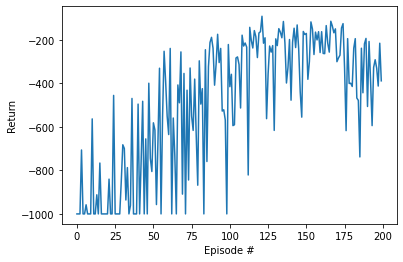

In [ ]:
#plot the returns
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(returns)),returns)
plt.ylabel('Return')
plt.xlabel('Episode #')
plt.show()

If training has been successfull you should see an animation showing the acrobot being swung above the line. (The animation here can be very slow as it requires a workaround to display on colab)

[-412.0]

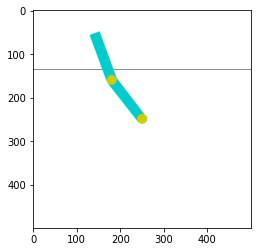

In [ ]:
train_DQN(agent, env, n_episodes=1, display=True, eps_start=0, eps_end=0)